# Basic Stock Trading

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [21]:
#define the ticker symbol
tickerSymbol = 'JBLU'
tickers = ['NXE', 'CCL', 'PR', 'STNE', 'NAT', 'AMD', 'NVDA', 'UEC', 'XP', 'TSLA']

In [22]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

In [23]:
#get the historical prices for this ticker
start_date = "2023-01-01"
end_date = "2024-01-01"

tickerDf = tickerData.history(interval='1d', start=start_date, end=end_date)
tickerData = yf.download(tickers, interval='1d', start=start_date, end=end_date)

[*********************100%%**********************]  10 of 10 completed


In [24]:
priceData = tickerDf.Open
priceData = tickerData.Open

In [6]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

<Axes: >

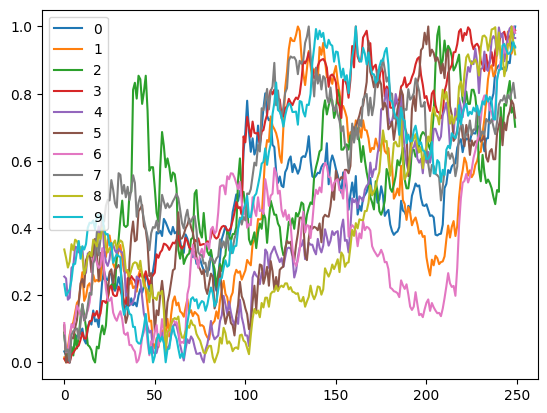

In [31]:
from sklearn import preprocessing

x = priceData.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pd.DataFrame(x_scaled).plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Price Data')

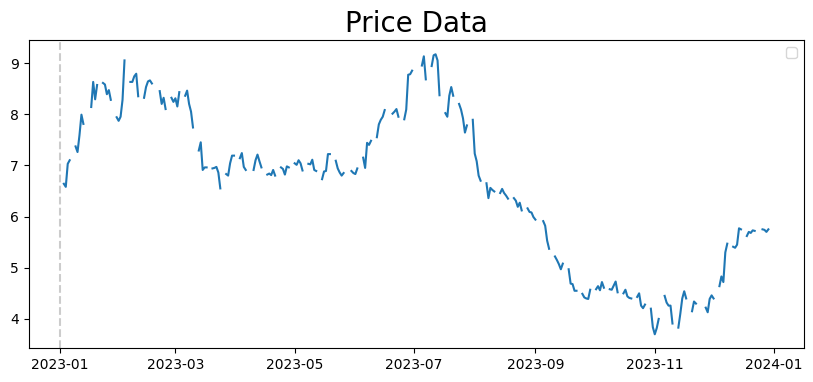

In [9]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
plt.legend()
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
# plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.title("Price Data", fontsize=20)

# import seaborn as sns

# sns.lineplot(data=priceData.replace('nan', float('nan')).melt(id_vars=['Date']),
#              x='Date', y='value', hue='variable'
#             )

## Basic Buying Protocol:

### - Buy if stock increasing for $b$ consecutive days

## Basic Selling Protocols:

### - Sell if stock decreasing for $s$ consecutive days (and we've made a profit)

In [10]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [70]:
info_dict = get_buying_selling_days(priceData, 3, 1)

In [71]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [72]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [73]:
df_stocks = {}
for ticker in tickers:
    info_dict = get_buying_selling_days(priceData[ticker], 4, 1)
    buying_days = info_dict['buying_days']
    potential_selling_days = info_dict['potential_selling_days']
    df_stock = pd.DataFrame(index = buying_days.index)
    df_stocks[ticker] = df_stock

In [74]:
#populate df with buying days, possible selling days, and price
for ticker, df in df_stocks.items():
    df['buying_day'] = (buying_days == 1)
    df['potential_selling_day'] = (potential_selling_days == 1)
    df['price'] = priceData[ticker]

    #only keep days that are buying or possible selling days
    df = df[(df.buying_day | df.potential_selling_day)]
    df_stocks[ticker] = df

In [75]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [76]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [79]:
avg_return = 0
for ticker, df in df_stocks.items():
    percent_change, events_list = get_investing_result(df, 1000, False)
    avg_return += percent_change
avg_return /= len(tickers)
print(f"Strategy: buy when stock go up for 3 consecutive, sell when go down for 1 consecutive day")
print(f"Return: {avg_return}")

Strategy: buy when stock go up for 3 consecutive, sell when go down for 1 consecutive day
Return: 0.164


In [78]:
nasdaqData = yf.download("QQQ", interval='1d', start=start_date, end=end_date)
nasdaqReturn = (nasdaqData['Close'].iloc[-1] - nasdaqData['Close'].iloc[0]) / nasdaqData['Close'].iloc[0] 
print(f"Strategy: buy and hold QQQ for 1 year")
print(f"Return: {nasdaqReturn}")

[*********************100%%**********************]  1 of 1 completed

Strategy: buy and hold QQQ for 1 year
Return: 0.5483967483457242


In [ ]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 1257 shares at $7.949999809265137 on 2023-06-15 totaling $9993.15
Sold 1257 shares at $8.010000228881836 on 2023-06-20 totaling $10068.57
--------------------------------------
Bought 1138 shares at $8.850000381469727 on 2023-06-30 totaling $10071.3
Sold 1138 shares at $9.050000190734863 on 2023-07-13 totaling $10298.9
--------------------------------------


In [ ]:
print(percent_change)

0.03


(3.0, 9.0)

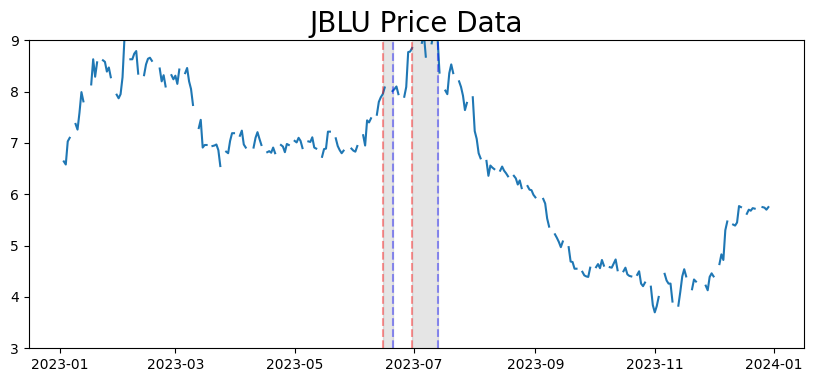

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)